In [1]:
import numpy as np
import pandas as pd 
pd.set_option("max_columns",None)
from sklearn.linear_model import LinearRegression, Ridge

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer,r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import Lasso, Ridge, SGDRegressor,LinearRegression,RidgeCV,ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,RobustScaler
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor,DecisionTreeRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error,make_scorer,r2_score,mean_absolute_percentage_error,explained_variance_score

pd.set_option('max_columns', 200)



In [2]:
#df = pd.ExcelFile('C:/Users/halil/Desktop/soalr_data.xlsx').parse('sheet 1')
weather_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="weather")
guneko_raw = pd.read_excel('C:/Users/halil/Desktop/soalr_data.xlsx',sheet_name="1000255-GUNEKO")

In [3]:
#normalization in range (-1,1)
def normalize(df,column_list):
    for col in column_list:
        feature_range = (-1,1)
        min_max_scaler = MinMaxScaler(feature_range=feature_range)

        df[col] = min_max_scaler.fit_transform(df[col].values.reshape(-1,1))

    return df

In [4]:
#data initilization
guneko_production = guneko_raw[["Date","Production"]]
guneko_gti = guneko_raw[["Date.1","GTI"]]

weather_guneko = weather_raw.loc[weather_raw.name ==1000255]
ali = pd.merge(guneko_production,weather_guneko,left_on="Date",right_on="date")
dataset = ali.drop(["name","date","lat","lon"],axis=1)

#encoding for not numerical datas 
dataset= dataset.set_index(["Date"])
year = pd.DataFrame(data=pd.get_dummies(dataset.index.year,prefix="year"))
month = pd.DataFrame(data=pd.get_dummies(dataset.index.month, prefix="month"))
#day = pd.DataFrame(data=pd.get_dummies(dataset.index.day,prefix="day"))
hour = pd.DataFrame(data=pd.get_dummies(dataset.index.hour,prefix="hour"))
#frames = [year,month,day,hour]
frames = [year,month,hour]
onehot_encoded = ali.join(frames)

#dropping useless features
onehot_encoded = onehot_encoded.drop(["Date","name","date","lat","lon"],axis=1)

normalized = normalize(onehot_encoded,onehot_encoded.columns[0:11])

#choosing specific year for train data, so other years can be drop
target = normalized.loc[normalized.year_2021 == 1]
target = target.drop(["year_2020","year_2022","year_2021"],axis=1)
target = target.reset_index(drop=True)




In [5]:

months = []

for i in target.columns[11:23]:
    month = target.loc[target[f"{i}"]== 1].copy()
    aw1 = month.reset_index(drop=True)
    months.append(aw1)

In [6]:
def make_data(dataframe):
    train = dataframe[:len(dataframe)- 24*5]
    test = dataframe[len(dataframe)- 24*5:]


    x_train = train.copy()
    x_test = test.copy()

    y_train = x_train.pop('Production')
    y_test = x_test.pop('Production')

    return x_train, x_test, y_train, y_test 

In [7]:


def metrics(y_train1,y_train_pred1,y_test1,y_test_pred1):
    print("for train data, mean squared error is",mean_squared_error(y_train1, y_train_pred1))
    print("for train data, mean absolute error is:",mean_absolute_error(y_train1, y_train_pred1))
    print("for train data, mean absolute percentage error is",mean_absolute_percentage_error(y_train1, y_train_pred1),"\n")

    print("for test data, mean squared error is",mean_squared_error(y_test1, y_test_pred1))
    print("for test data, mean absolute error is:",mean_absolute_error(y_test1, y_test_pred1))
    print("for test data, mean absolute percentage error is",mean_absolute_percentage_error(y_test1, y_test_pred1),"\n")


In [8]:
def calculate_ridge(train_x,test_x,train_y,test_y):
    ridge_reg = Ridge(alpha=1) 

    ridge_reg.fit(train_x,train_y)

    ridge_train_1 = ridge_reg.predict(train_x)
    ridge_test_1 = ridge_reg.predict(test_x)

    return mean_squared_error(train_y, ridge_train_1), mean_squared_error(test_y, ridge_test_1)



def calculate_lasso(train_x_2,test_x_2,train_y_2,test_y_2):

    lasso_reg = Lasso(alpha=0.1)
    lasso_reg.fit(train_x_2,train_y_2)
    lasso_train_2 = lasso_reg.predict(train_x_2)
    lasso_test_2 = lasso_reg.predict(test_x_2)
    
    return mean_squared_error(train_y_2, lasso_train_2), mean_squared_error(test_y_2, lasso_test_2)
    

In [58]:
#main loop
#del errors
errors = []
for number, month in enumerate(months,start=1):

    x_train, x_test, y_train, y_test = make_data(month)

    ridge = calculate_ridge(x_train, x_test, y_train, y_test)

    lasso = calculate_lasso(x_train, x_test, y_train, y_test)

    errors.append({f"ridge":ridge,"lasso":lasso})



In [11]:
x_train, x_test, y_train, y_test = make_data(months[2])

In [33]:
ridge_reg = Ridge(alpha=1) 

ridge_reg.fit(x_train,y_train)

y_pred_train = ridge_reg.predict(x_train)
y_pred = ridge_reg.predict(x_test)
print("Ridge Model results")
#metrics(y_train,y_pred_train,y_test,y_pred)

print(ridge_reg.score(x_train,y_train)*100)
scores = cross_val_score(ridge_reg, x_train, y_train)
print(scores)

Ridge Model results
89.24021229783848
[0.90249772 0.91648518 0.86720398 0.84242477 0.4196985 ]


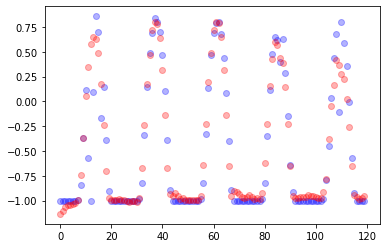

In [20]:
import matplotlib.pyplot as plt
_, ax = plt.subplots()

ax.scatter(x = range(0, y_test.size), y=y_test, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, y_pred.size), y=y_pred, c = 'red', label = 'Predicted', alpha = 0.3)

plt.title('Actual and predicted values')
plt.xlabel('Observations')
plt.ylabel('mpg')
plt.legend()
plt.show()

In [53]:
import plotly.express as px
data_canada = px.data.gapminder().query("country == 'Canada'")
fig = px.bar(data_canada, x='year', y='pop')
fig.show()
data_canada

,country,continent,year,lifeExp,pop,gdpPercap,iso_alpha,iso_num
240,Canada,Americas,1952,68.750,14785584,11367.16112,CAN,124
241,Canada,Americas,1957,69.960,17010154,12489.95006,CAN,124
242,Canada,Americas,1962,71.300,18985849,13462.48555,CAN,124
243,Canada,Americas,1967,72.130,20819767,16076.58803,CAN,124
244,Canada,Americas,1972,72.880,22284500,18970.57086,CAN,124
245,Canada,Americas,1977,74.210,23796400,22090.88306,CAN,124
246,Canada,Americas,1982,75.760,25201900,22898.79214,CAN,124
247,Canada,Americas,1987,76.860,26549700,26626.51503,CAN,124
248,Canada,Americas,1992,77.950,28523502,26342.88426,CAN,124
249,Canada,Americas,1997,78.610,30305843,28954.92589,CAN,124


In [69]:
ridge_train =[]
ridge_test = []
lasso_train = []
lasso_test = []
for i in errors:
    ridge_train.append(i["ridge"][0])
    ridge_test.append(i["ridge"][1])
    lasso_train.append(i["lasso"][0])
    lasso_test.append(i["lasso"][1])

aylar = ["January","February","March","April","May","June","July","August","September","October","November","December"]

seri1  = pd.Series(ridge_train) 
seri2  = pd.Series(ridge_test) 
seri3  = pd.Series(lasso_train) 
seri4  = pd.Series(lasso_test) 
seri5 = pd.Series(aylar)

frame = {"months":seri5,"ridge_train":ridge_train, "ridge_test":ridge_test,"lasso_train":lasso_train,"lasso_test":lasso_test}
result = pd.DataFrame(frame)

In [77]:
result

,months,ridge_train,ridge_test,lasso_train,lasso_test
0,January,0.025617,0.026917,0.132116,0.094282
1,February,0.038218,0.013941,0.118888,0.184939
2,March,0.028792,0.047554,0.092748,0.157292
3,April,0.043728,0.068523,0.099300,0.115175
4,May,0.015842,0.037779,0.076165,0.077691
5,June,0.015064,0.051915,0.085505,0.086993
6,July,0.046060,0.011202,0.120937,0.099683
7,August,0.024422,0.003242,0.085563,0.066590
8,September,0.010137,0.007507,0.079217,0.092934
9,October,0.011385,0.045008,0.087632,0.062453
